## Mnist Dataset Classification using K-Nearest Neighbors (Euclidean)

### Summary
<img align="right" src="../image/NearestNeighbor.png" width=150 height=150>
KNN은 새로운 데이터가 주어졌을 때 기존 데이터 가운데 가장 가까운 k개 이웃의 정보로 새로운 데이터를 예측하는 알고리즘

새로운 데이터가 주어진 경우 기존 모든 데이터와의 거리를 계산한다. 계산된 거리 값이 작은 k개의 데이터를 선정한다. 새로운 데이터의 클래스는 선정된 데이터들의 클래스 중 가장 많이 선택된 클래스로 분류한다.

거리 계산 방법에는 Euclidean, Mahalanobis 등 있다.

Mnist 데이터셋을 이용하여 0부터 9까지의 10가지 손글씨 클래스를 구분한다. 거리 계산 방법은 Euclidean을 사용한다.

Time 측정 방법은 Method 측면에서는 
1. Model Fitting Time : KNN의 경우 데이터셋에 대한 Checking 및 데이터셋 메모리에 카피
2. All Test Data Prediction Time
3. One Instance Prediction Time 10번 평균

PCA 측면에서는 
1. Calculate Train Data SVD Matrix Time
2. Transform Train X to N-PCA Time
3. Transform Test X to N-PCA Time

In [2]:
import time
from tqdm import tqdm
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from torchvision.datasets import MNIST

In [3]:
class BaseConfig:
    def __init__(self):
        pass

    def info(self):
        config_list = {
            0 : ['Dataset', self.dataset, 
                 "Train size: " + str(int((1-self.test_size)*100))+"%",
                 'Feature size: ' + str(self.feature_size), 1],
            1 : ['Method', self.method, 
                 "k = " + str(self.k), self.distance, 2],
            2 : ['Dimension reduction', 
                 'Method: ' + str(self.reduction_method[0]),
                 'Component size: ' + str(self.reduction_method[1]),
                 'Feature Reduction Ratio: ' + \
                    str(round(self.reduction_method[1]/self.feature_size, 3)*100 if self.reduction_method[1] is not None else None)+"%", 3],
            3 : ['Iteration', str(self.iter), -1]
        }

        print("Device " + "─" * 2 + " " + self.device)
        print("│")

        parent = 1
        for child in range(len(config_list)):
            for idx, contents in enumerate(config_list[child][:-1]):
                if idx == 0 and child == len(config_list)-1:
                    print("└" + "─" * 2 + contents)
                elif idx == 0:
                    print("├" + "─" * 2 + contents)
                elif child == len(config_list)-1:
                    print(" " * 4 + "└" + "─" * 4 + contents)
                else:
                    print("│" + " " * 4 + "└" + "─" * 4 + contents)
            parent = config_list[child][-1]
            if parent == -1: break
            print("│")

class Config(BaseConfig):
    def __init__(self):
        super(BaseConfig, self).__init__()
        self.device = 'PC'
        self.dataset = 'Mnist'
        self.test_size = 0.2
        self.feature_size = 784
        self.method = 'kNN'
        self.k = 1
        self.distance = 'Euclidean'
        self.reduction_method = [None, None] # method, n_components
        self.iter = 10


# Load Mnist Dataset

<a title="By Josef Steppan [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)], from Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:MnistExamples.png"><img width="512" alt="MnistExamples" src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"/></a>

In [105]:
train_mnist = MNIST(root='../../datasets', train=True, download=False)
test_mnist = MNIST(root='../../datasets', train=False, download=False)

In [106]:
train_mnist_X, train_mnist_y = train_mnist.data.numpy(), train_mnist.targets.numpy()
test_mnist_X, test_mnist_y = test_mnist.data.numpy(), test_mnist.targets.numpy()

print(f'Train data X shape : {train_mnist_X.shape}, y shape : {train_mnist_y.shape}')
print(f'Test data X shape : {test_mnist_X.shape}, y shape : {test_mnist_y.shape}')

Train data X shape : (60000, 28, 28), y shape : (60000,)
Test data X shape : (10000, 28, 28), y shape : (10000,)


In [107]:
print(f'Mnist Data range [{train_mnist_X.min()}, {train_mnist_X.max()}] ')

train_mnist_X, test_mnist_X = train_mnist_X / 255., test_mnist_X / 255.

print(f'--> Mnist Data Normalized range [{train_mnist_X.min()}, {train_mnist_X.max()}] ')

Mnist Data range [0, 255] 
--> Mnist Data Normalized range [0.0, 1.0] 


## Sample Images

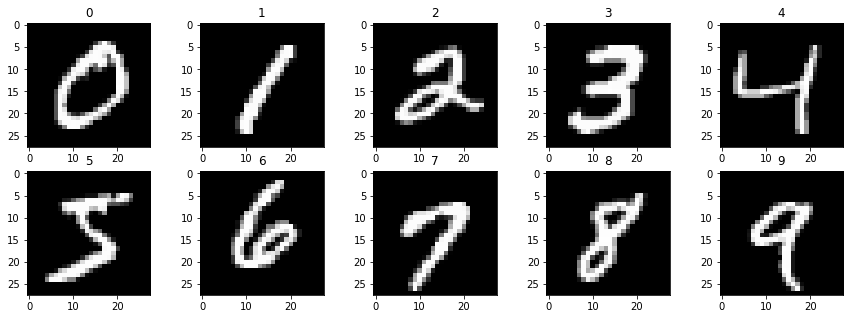

In [108]:
plt.figure(figsize=(15, 5))

for i in range(10):
    sample_idx = np.where(train_mnist_y == i)[0][0]

    sample_image = train_mnist_X[sample_idx]
    sample_label = train_mnist_y[sample_idx]

    plt.subplot(2, 5, i+1) # nrows, ncolumns, index
    plt.title(sample_label)
    plt.imshow(sample_image,'gray')
plt.show()

## Train & Test Data Label Distribution

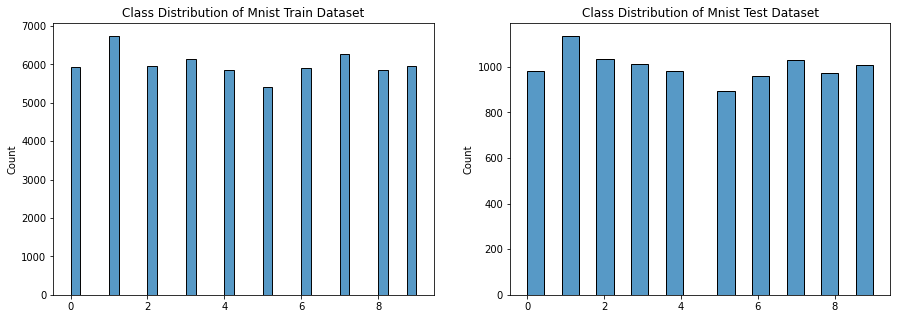

In [109]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(train_mnist_y, palette="tab10")
plt.title("Class Distribution of Mnist Train Dataset")

plt.subplot(1, 2, 2)
sns.histplot(test_mnist_y, palette="tab10")
plt.title("Class Distribution of Mnist Test Dataset")
plt.show()

## Preprocessing
 * Flatten 28 x 28 images to 784 vectors

In [110]:
print(f'Mnist Data shape train : {train_mnist_X.shape}, test : {test_mnist_X.shape}')

train_mnist_X = train_mnist_X.reshape(-1, 784)
test_mnist_X = test_mnist_X.reshape(-1, 784)

print(f'--> Mnist Data shape train : {train_mnist_X.shape}, test : {test_mnist_X.shape}')

Mnist Data shape train : (60000, 28, 28), test : (10000, 28, 28)
--> Mnist Data shape train : (60000, 784), test : (10000, 784)


## K-Nearest Neighbor

In [90]:
config = Config()
config.info()

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 1
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: None
│    └────Component size: None
│    └────Feature Reduction Ratio: None%
│
└──Iteration
    └────10


In [123]:
def knn_run(train_data_X = train_mnist_X,
            train_data_y = train_mnist_y,
            test_data_X = test_mnist_X,
            test_data_y = test_mnist_y,
            config = None,
            weights = 'distance'):

    assert config is not None
    config.info()
    k = config.k
    max_seed = config.iter

    avg_test_acc = []
    avg_knn_fit_time = []
    avg_pred_time = []
    preds = []

    for seed in tqdm(range(max_seed)):
        x_train, x_test, y_train, y_test = train_data_X, test_data_X, train_data_y, test_data_y

        knn = KNeighborsClassifier(n_neighbors=k, weights=weights, n_jobs=-1)

        start_time = time.perf_counter()
        knn.fit(x_train, y_train)
        knn_fit_time = time.perf_counter() - start_time
        avg_knn_fit_time.append(knn_fit_time)

        start_time = time.perf_counter()
        pred = knn.predict(x_test)
        pred_time = time.perf_counter() - start_time
        preds.append(pred)

        test_score = accuracy_score(pred, y_test)
        avg_test_acc.append(test_score)
        avg_pred_time.append(pred_time)

    print("Train size : ", len(x_train), " / Test size : ", len(x_test))
    print("-----" * 8)
    print("Test set score: %f" % np.array(avg_test_acc).mean())
    print("KNN fitting Time: %.4f ± %.5f" % (np.array(avg_knn_fit_time).mean(), np.array(avg_knn_fit_time).std()), "sec")
    print("All Test dataset Prediction Time at once : %.4f ± %.5f" % (np.array(avg_pred_time).mean(), np.array(avg_pred_time).std()), "sec")
    print("Divide the Prediction Time by Test size : %.8f ± %.8f" % (np.array(avg_pred_time).mean()/len(x_test)*1e6, np.array(avg_pred_time).std()/len(x_test)*1e6), "microsec")

    return avg_test_acc, avg_knn_fit_time, avg_pred_time

In [127]:
config.k = 1

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_mnist_X,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_mnist_X,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 1
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: None
│    └────Component size: None
│    └────Feature Reduction Ratio: None%
│
└──Iteration
    └────10


100%|██████████| 10/10 [01:28<00:00,  8.81s/it]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.969100
KNN fitting Time: 0.0522 ± 0.00184 sec
All Test dataset Prediction Time at once : 8.7566 ± 0.10173 sec
Divide the Prediction Time by Test size : 875.66143200 ± 10.17253561 microsec


In [128]:
config.k = 2

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_mnist_X,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_mnist_X,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 2
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: None
│    └────Component size: None
│    └────Feature Reduction Ratio: None%
│
└──Iteration
    └────10


100%|██████████| 10/10 [01:32<00:00,  9.23s/it]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.969100
KNN fitting Time: 0.0536 ± 0.00562 sec
All Test dataset Prediction Time at once : 9.1738 ± 0.10404 sec
Divide the Prediction Time by Test size : 917.38246400 ± 10.40376709 microsec


In [129]:
config.k = 3

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_mnist_X,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_mnist_X,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 3
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: None
│    └────Component size: None
│    └────Feature Reduction Ratio: None%
│
└──Iteration
    └────10


100%|██████████| 10/10 [01:37<00:00,  9.73s/it]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.971700
KNN fitting Time: 0.0536 ± 0.00362 sec
All Test dataset Prediction Time at once : 9.6748 ± 0.08815 sec
Divide the Prediction Time by Test size : 967.48117100 ± 8.81450653 microsec


### 1개의 Instance를 예측하는데 걸리는 시간 측정 - 10번 반복

In [143]:
def knn_run_one_instance(train_data_X = train_mnist_X,
            train_data_y = train_mnist_y,
            test_data_X = test_mnist_X,
            test_data_y = test_mnist_y,
            config = None,
            weights = 'distance'):

    assert config is not None
    config.info()
    k = config.k
    max_seed = config.iter


    x_train, x_test, y_train, y_test = train_data_X, test_data_X, train_data_y, test_data_y

    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', n_jobs=-1)

    start_time = time.perf_counter()
    knn.fit(x_train, y_train)
    knn_fit_time = time.perf_counter() - start_time


    avg_pred_time = []
    preds = []
    ys_test = []
    count = 0

    for x_one, y_one in tqdm(zip(x_test, y_test)):
        x_one = x_one.reshape(1, -1)

        start = time.perf_counter()
        pred = knn.predict(x_one)
        pred_time = time.perf_counter() - start
        

        avg_pred_time.append(pred_time)
        preds.append(pred)
        ys_test.append(y_one)

        count += 1
        if count == 10:
            break

    test_score = accuracy_score(preds, ys_test)
    avg_test_acc.append(test_score)
    avg_pred_time.append(pred_time)

    print("Train size : ", len(x_train), " / Test size : ", 10)
    print("-----" * 8)
    print("Test set score: %f" % np.array(avg_test_acc).mean())
    print("KNN fitting Time: %.4f" % (knn_fit_time), "sec")
    print("One Instance Prediction Average Time : %.8f ± %.8f" % (np.array(avg_pred_time).mean(), np.array(avg_pred_time).std()), "microsec")

    return avg_test_acc, knn_fit_time, avg_pred_time

In [144]:
config.k = 1

avg_test_acc, knn_fit_time, avg_pred_time = knn_run_one_instance(train_data_X = train_mnist_X,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_mnist_X,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 1
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: None
│    └────Component size: None
│    └────Feature Reduction Ratio: None%
│
└──Iteration
    └────10


9it [00:01,  8.09it/s]

Train size :  60000  / Test size :  10
----------------------------------------
Test set score: 0.976417
KNN fitting Time: 0.0541 sec
One Instance Prediction Average Time : 0.11068453 ± 0.00213057 microsec


In [145]:
config.k = 2

avg_test_acc, knn_fit_time, avg_pred_time = knn_run_one_instance(train_data_X = train_mnist_X,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_mnist_X,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 2
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: None
│    └────Component size: None
│    └────Feature Reduction Ratio: None%
│
└──Iteration
    └────10


9it [00:01,  8.15it/s]

Train size :  60000  / Test size :  10
----------------------------------------
Test set score: 0.978231
KNN fitting Time: 0.0592 sec
One Instance Prediction Average Time : 0.11001748 ± 0.00104367 microsec


In [146]:
config.k = 3

avg_test_acc, knn_fit_time, avg_pred_time = knn_run_one_instance(train_data_X = train_mnist_X,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_mnist_X,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 3
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: None
│    └────Component size: None
│    └────Feature Reduction Ratio: None%
│
└──Iteration
    └────10


9it [00:01,  8.06it/s]

Train size :  60000  / Test size :  10
----------------------------------------
Test set score: 0.979786
KNN fitting Time: 0.0549 sec
One Instance Prediction Average Time : 0.11105071 ± 0.00236016 microsec


In [173]:
n_components_list = []
pca_fit_time_list = []
train_features_extract_time_list = []
test_features_extract_time_list = []

### kNN with PCA feature 2

### Time of calculating PCA

In [174]:
def pca_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=None):

    assert config is not None
    config.info()

    n_components = config.reduction_method[1]

    pca_dims = PCA(n_components)
    print(f"The number of components : {n_components}")

    start_time = time.perf_counter()
    pca_dims.fit(train_data_X)
    pca_fit_time = time.perf_counter () - start_time
    print()
    print(f"Calculating SVD Matrix Time on Train Data-{train_data_X.shape} : {pca_fit_time:4f} sec")
    
    start_time = time.perf_counter()
    train_features = pca_dims.transform(train_data_X)
    train_features_extract_time = time.perf_counter () - start_time
    print(f"Transform train X-{train_data_X.shape} to {n_components}-PCA Time: {train_features_extract_time:4f} sec")

    start_time = time.perf_counter()
    test_features = pca_dims.transform(test_data_X)
    test_features_extract_time = time.perf_counter () - start_time
    print(f"Transform test X-{train_data_X.shape} to {n_components}-PCA Time: {test_features_extract_time:4f} sec")

    return pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time
    

In [216]:
config.reduction_method = ['PCA', 2]

pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time = \
    pca_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=config)

n_components_list.append(config.reduction_method[1])
pca_fit_time_list.append(pca_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 43
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 2
│    └────Feature Reduction Ratio: 0.3%
│
└──Iteration
    └────10
The number of components : 2

Calculating Train Data SVD Matrix Time: 1.156580 sec
Transform train X to 2-PCA Time: 0.197202 sec
Transform test X to 2-PCA Time: 0.033457 sec


In [177]:
config.k = 2

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 2
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 2
│    └────Feature Reduction Ratio: 0.3%
│
└──Iteration
    └────10


100%|██████████| 10/10 [00:01<00:00,  6.72it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.389700
KNN fitting Time: 0.0341 ± 0.00222 sec
All Test dataset Prediction Time at once : 0.1136 ± 0.00576 sec
Divide the Prediction Time by Test size : 11.35826000 ± 0.57626983 microsec


### kNN with PCA feature 3

In [217]:
config.reduction_method = ['PCA', 3]

pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time = \
    pca_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=config)

n_components_list.append(config.reduction_method[1])
pca_fit_time_list.append(pca_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 43
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 3
│    └────Feature Reduction Ratio: 0.4%
│
└──Iteration
    └────10
The number of components : 3

Calculating Train Data SVD Matrix Time: 1.197905 sec
Transform train X to 3-PCA Time: 0.181247 sec
Transform test X to 3-PCA Time: 0.036096 sec


In [179]:
config.k = 3

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 3
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 3
│    └────Feature Reduction Ratio: 0.4%
│
└──Iteration
    └────10


100%|██████████| 10/10 [00:01<00:00,  6.27it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.460000
KNN fitting Time: 0.0451 ± 0.00117 sec
All Test dataset Prediction Time at once : 0.1134 ± 0.00359 sec
Divide the Prediction Time by Test size : 11.34198800 ± 0.35865382 microsec


### kNN with PCA feature 4

In [218]:
config.reduction_method = ['PCA', 4]

pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time = \
    pca_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=config)

n_components_list.append(config.reduction_method[1])
pca_fit_time_list.append(pca_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 43
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 4
│    └────Feature Reduction Ratio: 0.5%
│
└──Iteration
    └────10
The number of components : 4

Calculating Train Data SVD Matrix Time: 1.122042 sec
Transform train X to 4-PCA Time: 0.189472 sec
Transform test X to 4-PCA Time: 0.027155 sec


In [181]:
config.k = 4

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 4
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 4
│    └────Feature Reduction Ratio: 0.5%
│
└──Iteration
    └────10


100%|██████████| 10/10 [00:01<00:00,  5.73it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.620300
KNN fitting Time: 0.0568 ± 0.00262 sec
All Test dataset Prediction Time at once : 0.1167 ± 0.00290 sec
Divide the Prediction Time by Test size : 11.67230100 ± 0.28976851 microsec


### kNN with PCA feature 5

In [219]:
config.reduction_method = ['PCA', 5]

pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time = \
    pca_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=config)

n_components_list.append(config.reduction_method[1])
pca_fit_time_list.append(pca_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 43
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 5
│    └────Feature Reduction Ratio: 0.6%
│
└──Iteration
    └────10
The number of components : 5

Calculating Train Data SVD Matrix Time: 1.183685 sec
Transform train X to 5-PCA Time: 0.195734 sec
Transform test X to 5-PCA Time: 0.027315 sec


In [183]:
config.k = 5

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 5
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 5
│    └────Feature Reduction Ratio: 0.6%
│
└──Iteration
    └────10


100%|██████████| 10/10 [00:01<00:00,  5.34it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.745000
KNN fitting Time: 0.0673 ± 0.00092 sec
All Test dataset Prediction Time at once : 0.1191 ± 0.00376 sec
Divide the Prediction Time by Test size : 11.90542200 ± 0.37563551 microsec


### kNN with PCA feature 26

In [220]:
config.reduction_method = ['PCA', 26]

pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time = \
    pca_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=config)

n_components_list.append(config.reduction_method[1])
pca_fit_time_list.append(pca_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 43
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 26
│    └────Feature Reduction Ratio: 3.3000000000000003%
│
└──Iteration
    └────10
The number of components : 26

Calculating Train Data SVD Matrix Time: 1.889840 sec
Transform train X to 26-PCA Time: 0.241826 sec
Transform test X to 26-PCA Time: 0.032664 sec


In [210]:
config.k = 26

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 26
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 26
│    └────Feature Reduction Ratio: 3.3000000000000003%
│
└──Iteration
    └────10


100%|██████████| 10/10 [01:37<00:00,  9.77s/it]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.968200
KNN fitting Time: 0.0045 ± 0.00050 sec
All Test dataset Prediction Time at once : 9.7620 ± 0.11073 sec
Divide the Prediction Time by Test size : 976.19820000 ± 11.07274790 microsec


### kNN with PCA feature 43

In [221]:
config.reduction_method = ['PCA', 43]

pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time = \
    pca_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=config)

n_components_list.append(config.reduction_method[1])
pca_fit_time_list.append(pca_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 43
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 43
│    └────Feature Reduction Ratio: 5.5%
│
└──Iteration
    └────10
The number of components : 43

Calculating Train Data SVD Matrix Time: 1.994393 sec
Transform train X to 43-PCA Time: 0.255927 sec
Transform test X to 43-PCA Time: 0.033377 sec


In [214]:
config.k = 43

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config,
                                                        weights = 'distance')

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 43
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 43
│    └────Feature Reduction Ratio: 5.5%
│
└──Iteration
    └────10


100%|██████████| 10/10 [01:37<00:00,  9.71s/it]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.964800
KNN fitting Time: 0.0056 ± 0.00017 sec
All Test dataset Prediction Time at once : 9.7001 ± 0.20350 sec
Divide the Prediction Time by Test size : 970.01017600 ± 20.35014620 microsec


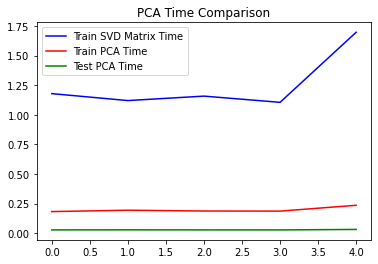

In [211]:
plt.figure()
plt.plot(pca_fit_time_list, "b", label="Train SVD Matrix Time")
plt.legend()
plt.plot(train_features_extract_time_list, "r", label="Train PCA Time")
plt.plot(test_features_extract_time_list, "g", label="Test PCA Time")
plt.legend()
plt.title("PCA Time Comparison")
plt.show()

In [186]:
import pandas as pd
df = pd.DataFrame()
df['n_components'] = n_components_list
df['train_svd'] = pca_fit_time_list
df['train_features'] = train_features_extract_time_list
df['test_features'] = test_features_extract_time_list

In [191]:
df

,n_components,train_svd,train_features,test_features
0,2,1.178987,0.182520,0.027847
1,3,1.120458,0.194239,0.028477
2,4,1.157993,0.187360,0.027883
3,5,1.105571,0.186498,0.027711


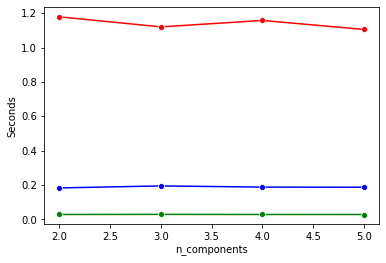

In [208]:
fig, ax1 = plt.subplots()

sns.lineplot(x='n_components', 
             y='train_svd',
             color='r',
             marker="o",
             ax=ax1,
             legend='auto',
             data=df)
# ax1.legend(["train_svd"], loc=1)


sns.lineplot(x='n_components', 
             y='train_features',
             color='b',
             marker="o",
             ax=ax1,
             data=df)
# ax1.legend(["train_features"], loc=1)

sns.lineplot(x='n_components', 
             y='test_features',
             color='g',
             marker="o",
             ax=ax1,
             data=df)
# ax1.legend(["test_features"], loc=1)

ax1.set_ylabel("Seconds")


plt.show()